# Imports and dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install umap-learn

In [ ]:
import numpy as np
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar100
from sklearn.datasets import load_digits
from sklearn.metrics import silhouette_score
import umap
import time
# For AE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from itertools import product
# For metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import json

sample_size = 700

def select_dataset(ds, ds_size):
  if ds == 1:
    (X, y), (_, _) = fashion_mnist.load_data()
    X, _, y, _ = train_test_split(X, y, train_size=ds_size, stratify=y, random_state=42)

    X = X.reshape(-1, 28*28)
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)

    return X, y

  if ds == 2:
    digits = load_digits()
    X, y = digits.data, digits.target
    X = X.reshape(-1, 8*8)
    X, _, y, _ = train_test_split(X, y, train_size=ds_size, stratify=y, random_state=42)

    return X, y

  if ds == 3:
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()

    selected_classes = list(range(50))
    train_mask = np.isin(y_train, selected_classes).flatten()

    x_train_50 = x_train[train_mask]
    y_train_50 = y_train[train_mask]

    X_50 = x_train_50.reshape(-1, 32 * 32 * 3)

    X, _, y, _ = train_test_split(X_50, y_train_50, train_size=ds_size, stratify=y_train_50, random_state=42)

    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)

    return X, y

X, y = select_dataset(3, 4000)

# Transform functions

## PCA

In [ ]:
## reduction_scale = how many dimension we want to save
def transform_PCA(X, y, reduction_scale):
    result_dimension = int(X.shape[1] * reduction_scale)
    silh_score = silhouette_score(X, y)
    pca = PCA(n_components=result_dimension)
    start = time.time()
    X_pca = pca.fit_transform(X)
    end = time.time()
    silh_score_transform = silhouette_score(X_pca, y)
    reduction_time = end - start
    return [[{}, X_pca, reduction_time, silh_score_transform, silh_score]]

## Kernel PCA

In [ ]:
def transform_KernelPCA(X, y, reduction_scale):
    result = []
    result_dimension = int(X.shape[1] * reduction_scale)
    silh_score = silhouette_score(X, y)
    settings = [
        {"kernel": 'linear'},
        {"kernel": 'poly'},
        {"kernel": 'rbf'}
    ]

    for set_of_settins in settings:
      pca = KernelPCA(n_components=result_dimension, kernel = set_of_settins["kernel"])
      start = time.time()
      X_pca = pca.fit_transform(X)
      end = time.time()
      reduction_time = end - start
      silh_score_transform = silhouette_score(X_pca, y)
      result.append([set_of_settins, X_pca,reduction_time, silh_score_transform, silh_score])
    return result

## SVD

In [ ]:
def transform_SVD(X, y, reduction_scale):
    result = []
    result_dimension = int(X.shape[1] * reduction_scale)
    svd = TruncatedSVD(n_components=result_dimension)
    start = time.time()
    X_svd = svd.fit_transform(X)
    end = time.time()

    reduction_time = end - start
    silh_score = silhouette_score(X, y)
    silh_score_transform = silhouette_score(X_svd, y)
    return [[{}, X_svd, reduction_time, silh_score_transform, silh_score]]

## AE

In [ ]:
def transform_AE(X, y, reduction_scale):

    epochs_list = [100, 10]
    batch_size_list = [256, 128]
    settings = list(product(epochs_list, batch_size_list))

    results = []

    for epochs, batch_size in settings:
        settings = {
            "epochs": epochs,
            "batch_size": batch_size
        }

        input_dim = X.shape[1]
        encoding_dim = int(input_dim * reduction_scale)

        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoding_dim, activation='relu')(input_layer)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)

        autoencoder = Model(inputs=input_layer, outputs=decoded)
        encoder = Model(inputs=input_layer, outputs=encoded)

        autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        start = time.time()
        autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=0)
        end = time.time()
        reduction_time = float(end - start)

        X_encoded = encoder.predict(X)

        silh_score = float(silhouette_score(X, y))
        silh_score_transform = float(silhouette_score(X_encoded, y))

        results.append([settings, X_encoded.tolist(), reduction_time, silh_score_transform, silh_score])

    return results

## UMAP

In [ ]:
def transform_umap(X, y, reduction_scale):
    result = []
    result_dimension = int(X.shape[1] * reduction_scale)
    silh_score = silhouette_score(X, y)
    settings = [
        {"n_neighbors": 5, "min_dist": 0.1},
        {"n_neighbors": 15, "min_dist": 0.1},
        {"n_neighbors": 30, "min_dist": 0.5}
    ]
    for set_of_settings in settings:
        umap_model = umap.UMAP(
            n_components=result_dimension,
            n_neighbors=set_of_settings["n_neighbors"],
            min_dist=set_of_settings["min_dist"]
        )
        start = time.time()
        X_umap = umap_model.fit_transform(X)
        end = time.time()
        reduction_time = end - start
        silh_score_transform = silhouette_score(X_umap, y)

        result.append([set_of_settings, X_umap, reduction_time, silh_score_transform, silh_score])
    return result

## TSNE

In [ ]:
def transform_tsne(X, y, reduction_scale):
    result = []

    result_dimension = int(X.shape[1] * reduction_scale)
    silh_score = silhouette_score(X, y)
    settings = [
        {"perplexity": 5},
        {"perplexity": 20}
    ]
    for set_of_settings in settings:
        tsne = TSNE(n_components=result_dimension, method='exact', perplexity = set_of_settings["perplexity"])
        start = time.time()
        X_tsne = tsne.fit_transform(X)
        end = time.time()
        reduction_time = end - start
        silh_score_transform = silhouette_score(X_tsne, y)
        result.append([set_of_settings, X_tsne, reduction_time, silh_score_transform, silh_score])
    return result

##Without Trans

In [ ]:
def without_trans(X, y, reduction_scale):
    silh_score = silhouette_score(X, y)
    silh_score_transform = silhouette_score(X, y)

    return [[{}, X, 0, silh_score_transform, silh_score]]

# Metrics

In [ ]:
def model_accuracyKNN(X, y, sample_size):
  k = [3, 5, 7]

  results = {}
  for ki in k:
    model = KNeighborsClassifier(n_neighbors=ki, algorithm='brute')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=sample_size, stratify=y, random_state=42)

    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    train_time = end - start
    results[f"{ki}"] = {"accuracy": accuracy, "train_time": train_time}

  return results

def model_accuracySVM(X, y, sample_size):
    kernels = ['linear', 'poly', 'rbf']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=sample_size, stratify=y, random_state=42)

    results = {}
    for kernel in kernels:
      model = SVC(kernel=kernel, random_state=42)
      start = time.time()
      model.fit(X_train, y_train)
      end = time.time()
      y_pred = model.predict(X_test)

      accuracy = accuracy_score(y_test, y_pred)
      train_time = end - start
      results[f"{kernel}"] = {"accuracy" : accuracy , "train_time": train_time}

    return results

def model_accuracyXGBoost(X, y, sample_size):
    parameters = [
        {"n_estimators": 50, "max_depth": 3},
        {"n_estimators": 100, "max_depth": 5},
        {"n_estimators": 200, "max_depth": 7}
    ]

    results = {}
    for param in parameters:
        model = XGBClassifier(n_estimators=param["n_estimators"], max_depth=param["max_depth"], use_label_encoder=False, eval_metric="logloss")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=sample_size, stratify=y, random_state=42)
        start = time.time()
        model.fit(X_train, y_train)
        end = time.time()
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        train_time = end - start
        key = f"n_estimators={param['n_estimators']}, max_depth={param['max_depth']}"
        results[key] = {"accuracy": accuracy, "train_time": train_time}

    return results

def test_reduction_ratio(X, y, transform_function, test_size, json_name = None):
    print(json_name)
    results = {}
    reductions_ratio = [0.01, 0.03, 0.05, 0.1]
    for ratio in reductions_ratio:
      print(ratio)
      if ratio == 1:
        tranformed_tests = without_trans(X, y, ratio)
      else:
        tranformed_tests = transform_function(X, y, ratio)

      results_for_ratio = []
      for model_data in tranformed_tests:
        settings, X_transformed, time_transformed, silh_score_transform, silh_score = model_data
        data_SVM = model_accuracySVM(X_transformed, y, test_size)
        data_KNN = model_accuracyKNN(X_transformed, y, test_size)
        #data_XGBoost = model_accuracyXGBoost(X_transformed, y, test_size)
        dic = {
            "settings": settings,
            "time_transformed": time_transformed,
            "SVM": data_SVM,
            "KNN": data_KNN,
            #"XGBoost": data_XGBoost,
            "silh_score_transform": float(silh_score_transform),
            "silh_score": float(silh_score)
        }
        results_for_ratio.append(dic)
        if json_name is not None:
          with open(json_name, 'w') as json_file:
            json.dump(results, json_file, indent=4)

      results[f"{ratio}"] = results_for_ratio

    if json_name is not None:
      with open(json_name, 'w') as json_file:
        json.dump(results, json_file, indent=4)

    return results

In [ ]:
data_UMAP = test_reduction_ratio(X, y, transform_umap, sample_size, "UMAP_ds_1_min_red.json")

UMAP_ds_1_min_red.json
0.01


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConver

0.03


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarn

0.05


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarn

0.1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarn

0.15


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarn

0.2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarn

In [ ]:
# data_TSNE = test_reduction_ratio(X, y, transform_tsne, sample_size, "TSNE_ds_2_700.json")
# files.download('TSNE_ds_2_700.json')

In [ ]:
data_PCA = test_reduction_ratio(X, y, transform_PCA, sample_size, "PCA_ds_1_min_red.json")


PCA_ds_1_min_red.json
0.01


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.03


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.05


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [ ]:
data_KernelPCA  = test_reduction_ratio(X, y, transform_KernelPCA, sample_size, "KernelPCA_ds_1_min_red.json")

KernelPCA_ds_1_min_red.json
0.01


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.03


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.05


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [ ]:
data_SVD = test_reduction_ratio(X, y, transform_SVD, sample_size, "SVD_ds_1_min_red.json")

SVD_ds_1_min_red.json
0.01


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.03


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.05


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [ ]:
data_AE = test_reduction_ratio(X, y, transform_AE, sample_size, "AE_ds_1_min_red.json")

AE_ds_1_min_red.json
0.01
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.03
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.05
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.1
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

# Creating table from data

In [ ]:
def create_table_from_json(json_name, SVM = True, svm_allowed_types = [], KNN = True, knn_allowed_types = [], Xgboost = False):
  with open(json_name, 'r') as file:
      data = json.load(file)
      rows = []

      for key, values in data.items():
          for entry in values:
              time_transformed = entry["time_transformed"]
              silh_score_transform = entry["silh_score_transform"]
              silh_score = entry["silh_score"]

              if SVM:
                for svm_type, svm_values in entry["SVM"].items():
                    if svm_type in svm_allowed_types:
                      rows.append({
                          "Key": key,
                          "Model": f"SVM-{svm_type}",
                          "Accuracy": svm_values["accuracy"],
                          "Train Time": svm_values["train_time"],
                          "Time Transformed": time_transformed,
                          "Silhouette Transform": silh_score_transform,
                          "Silhouette Score": silh_score
                      })
              if KNN:
                for knn_k, knn_values in entry["KNN"].items():
                  if knn_k in knn_allowed_types:
                      rows.append({
                          "Key": key,
                          "Model": f"KNN-{knn_k}",
                          "Accuracy": knn_values["accuracy"],
                          "Train Time": knn_values["train_time"],
                          "Time Transformed": time_transformed,
                          "Silhouette Transform": silh_score_transform,
                          "Silhouette Score": silh_score
                      })
              if Xgboost:
                for xgboost_type, xgboost_values in entry["XGBoost"].items():
                    params = xgboost_type.split(", ")
                    n, m = 0, 0

                    for param in params:
                      if "n_estimators" in param:
                        n = param.split("=")[1]
                      if "max_depth" in param:
                        m = param.split("=")[1]

                    rows.append({
                        "Key": key,
                        "Model": f"XGBoost-n={n}, depth={m}",
                        "Accuracy": xgboost_values["accuracy"],
                        "Train Time": xgboost_values["train_time"],
                        "Time Transformed": time_transformed,
                        "Silhouette Transform": silh_score_transform,
                        "Silhouette Score": silh_score
                    })


      df = pd.DataFrame(rows)
      return df

# Plots

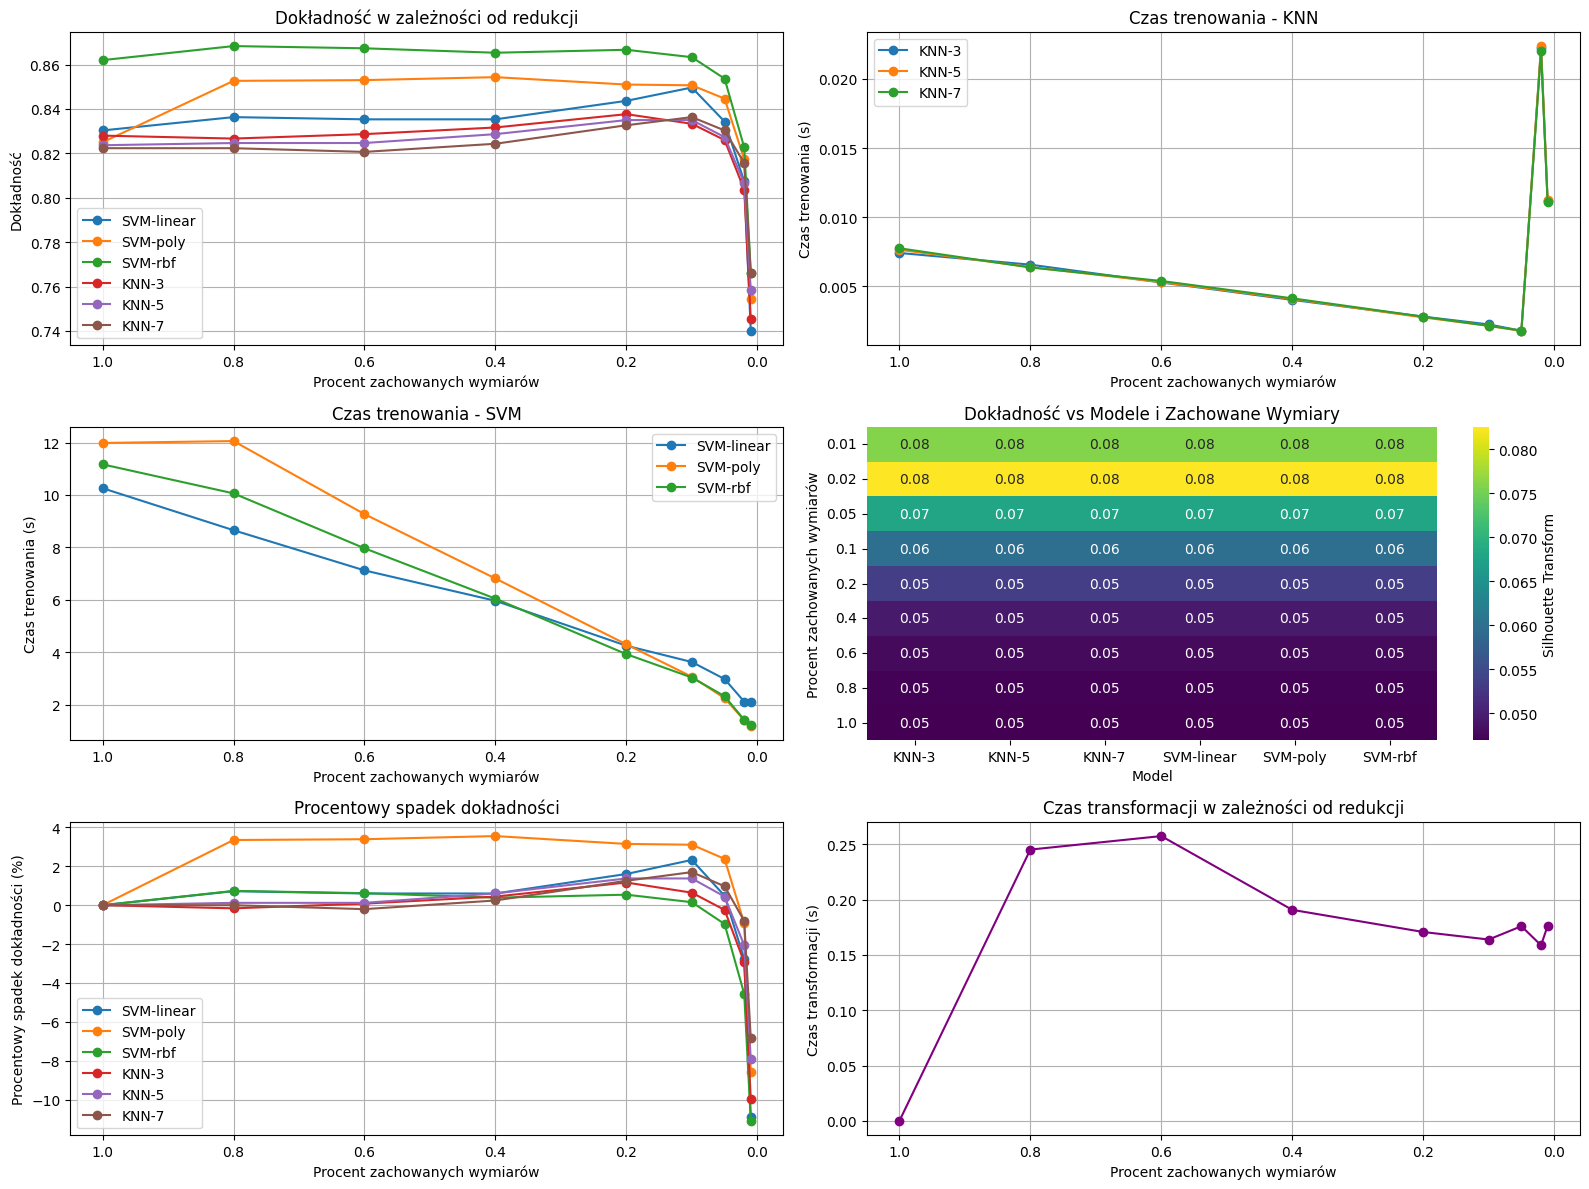

In [ ]:
def plot_from_table(df):
    df["Key"] = df["Key"].astype(float)
    unique_keys = sorted(df["Key"].unique(), reverse=True)
    models = df["Model"].unique()

    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    axes = axes.flatten()

    for model in models:
        model_data = df[df["Model"] == model]
        accuracies = [model_data[model_data["Key"] == key]["Accuracy"].max() for key in unique_keys]
        axes[0].plot(unique_keys, accuracies, marker='o', label=model)
    axes[0].invert_xaxis()
    axes[0].set_title("Dokładność w zależności od redukcji")
    axes[0].set_xlabel("Procent zachowanych wymiarów")
    axes[0].set_ylabel("Dokładność")
    axes[0].grid(True)
    axes[0].legend()

    baseline_accuracies = {model: df[(df["Model"] == model) & (df["Key"] == 1.0)]["Accuracy"].max() for model in models}

    for model, baseline in baseline_accuracies.items():
        model_data = df[df["Model"] == model]
        accuracies = [(model_data[model_data["Key"] == key]["Accuracy"].max() / baseline - 1) * 100 for key in unique_keys]
        axes[1].plot(unique_keys, accuracies, marker='o', label=model)
    axes[1].invert_xaxis()
    axes[1].set_title("Procentowy spadek dokładności")
    axes[1].set_xlabel("Procent zachowanych wymiarów")
    axes[1].set_ylabel("Procentowy spadek dokładności (%)")
    axes[1].grid(True)
    axes[1].legend()

    pivot_table = df.pivot_table(index="Key", columns="Model", values="Accuracy", aggfunc="max")
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Accuracy'}, ax=axes[2])
    axes[2].set_title("Dokładność vs Modele i Zachowane Wymiary")
    axes[2].set_xlabel("Model")
    axes[2].set_ylabel("Procent zachowanych wymiarów")

    pivot_table = df.pivot_table(index="Key", columns="Model", values="Silhouette Transform", aggfunc="max")
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Silhouette Transform'}, ax=axes[3])
    axes[3].set_title("Silhouette Transform vs Modele i Zachowane Wymiary")
    axes[3].set_xlabel("Model")
    axes[3].set_ylabel("Procent zachowanych wymiarów")

    knn_df = df[df["Model"].str.startswith("KNN")]
    svm_df = df[df["Model"].str.startswith("SVM")]

    if not knn_df.empty:
        models_knn = knn_df["Model"].unique()
        for model in models_knn:
            model_data = knn_df[knn_df["Model"] == model]
            times = [model_data[model_data["Key"] == key]["Train Time"].max() for key in unique_keys]
            axes[4].plot(unique_keys, times, marker='o', label=model)
        axes[4].invert_xaxis()
        axes[4].set_title("Czas trenowania - KNN")
        axes[4].set_xlabel("Procent zachowanych wymiarów")
        axes[4].set_ylabel("Czas trenowania (s)")
        axes[4].grid(True)
        axes[4].legend()

    if not svm_df.empty:
        models_svm = svm_df["Model"].unique()
        for model in models_svm:
            model_data = svm_df[svm_df["Model"] == model]
            times = [model_data[model_data["Key"] == key]["Train Time"].max() for key in unique_keys]
            axes[5].plot(unique_keys, times, marker='o', label=model)
        axes[5].invert_xaxis()
        axes[5].set_title("Czas trenowania - SVM")
        axes[5].set_xlabel("Procent zachowanych wymiarów")
        axes[5].set_ylabel("Czas trenowania (s)")
        axes[5].grid(True)
        axes[5].legend()

    plt.tight_layout()
    plt.show()

plot_from_table(df)

In [ ]:
# Zależność accuracy od ilości zachowanych wymiarów
def plot_average_accuracies_to_file(alg_dframes, names, filename_prefix, KNN_bool=True, SVM_bool=True, XGBoost_bool=False):
    plt.figure(figsize=(12, 8))

    for i, df in enumerate(alg_dframes):
        df["Key"] = df["Key"].astype(float)
        unique_keys = sorted(df["Key"].unique(), reverse=True)
        models = df["Model"].unique()

        KNN = []
        SVM = []
        XGBoost = []
        for model in models:
            model_data = df[df["Model"] == model]
            accuracies = [np.mean(model_data[model_data["Key"] == key]["Accuracy"]) for key in unique_keys] # średnie accuracy dla różnych wariacji algorytmów
            if model.startswith("KNN") and KNN_bool:
                KNN.append(accuracies)
            elif model.startswith("SVM") and SVM_bool:
                SVM.append(accuracies)
            elif model.startswith("XGBoost") and XGBoost_bool:
                XGBoost.append(accuracies)

        if KNN:
            averages_KNN = [np.mean([x[i] for x in KNN]) for i in range(len(KNN[0]))]
            plt.plot(unique_keys, averages_KNN, marker='o', label=f"KNN_{names[i]}")
        if SVM:
            averages_SVM = [np.mean([x[i] for x in SVM]) for i in range(len(SVM[0]))]
            plt.plot(unique_keys, averages_SVM, marker='o', label=f"SVM_{names[i]}")
        if XGBoost:
            averages_XGBoost = [np.mean([x[i] for x in XGBoost]) for i in range(len(XGBoost[0]))]
            plt.plot(unique_keys, averages_XGBoost, marker='o', label=f"XGBoost_{names[i]}")

    plt.gca().invert_xaxis()
    plt.xticks(unique_keys)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Percentage of preserved dimensions")
    plt.ylabel("Accuracy")

    filename = f"{filename_prefix}.jpg"
    plt.tight_layout()
    plt.savefig(filename, format="jpg")
    plt.close()
    return filename


Ta funkcja rysuje uśredniony wykres zależności czasu trenowania od accuracy i zapisuje go do pliku.


In [ ]:
def plot_train_times_and_accuracies(dataframes, labels, filename_prefix, include_knn=True, include_svm=True, include_xgboost=False):
    plt.figure(figsize=(12, 8))

    for i, df in enumerate(dataframes):
        df["Key"] = df["Key"].astype(float)
        unique_keys = sorted(df["Key"].unique(), reverse=True)
        models = df["Model"].unique()

        knn_times, knn_accuracies = [], []
        svm_times, svm_accuracies = [], []
        xgboost_times, xgboost_accuracies = [], []

        for model in models:
            model_data = df[df["Model"] == model]
            times = [np.mean(model_data[model_data["Key"] == key]["Train Time"]) for key in unique_keys]
            accuracies = [np.mean(model_data[model_data["Key"] == key]["Accuracy"]) for key in unique_keys]

            if model.startswith("KNN") and include_knn:
                knn_times.append(times)
                knn_accuracies.append(accuracies)
            elif model.startswith("SVM") and include_svm:
                svm_times.append(times)
                svm_accuracies.append(accuracies)
            elif model.startswith("XGBoost") and include_xgboost:
                xgboost_times.append(times)
                xgboost_accuracies.append(accuracies)

        if knn_times:
            avg_knn_times = np.mean(knn_times, axis=0)
            avg_knn_accuracies = np.mean(knn_accuracies, axis=0)
            plt.plot(avg_knn_accuracies, avg_knn_times, marker='o', label=f"KNN_{labels[i]}")

        if svm_times:
            avg_svm_times = np.mean(svm_times, axis=0)
            avg_svm_accuracies = np.mean(svm_accuracies, axis=0)
            plt.plot(avg_svm_accuracies, avg_svm_times, marker='o', label=f"SVM_{labels[i]}")

        if xgboost_times:
            avg_xgboost_times = np.mean(xgboost_times, axis=0)
            avg_xgboost_accuracies = np.mean(xgboost_accuracies, axis=0)
            plt.plot(avg_xgboost_accuracies, avg_xgboost_times, marker='o', label=f"XGBoost_{labels[i]}")

    plt.grid(True)
    plt.legend()
    plt.xlabel("Accuracy")
    plt.ylabel("Training Time (seconds)")

    filename = f"{filename_prefix}.jpg"
    plt.tight_layout()
    plt.savefig(filename, format="jpg")
    plt.close()
    return filename

svd_data = create_table_from_json('SVD_ds_2_1400_280_xg.json', SVM=True, svm_allowed_types=['linear', 'poly', 'rbf'], KNN=True, knn_allowed_types=['3', '5', '7'])
pca_data = create_table_from_json('PCA_ds_2_1400_280_xg.json', SVM=True, svm_allowed_types=['linear', 'poly', 'rbf'], KNN=True, knn_allowed_types=['3', '5', '7'])
kernel_data = create_table_from_json('KernelPCA_ds_2_1400_280_xg.json', SVM=True, svm_allowed_types=['linear', 'poly', 'rbf'], KNN=True, knn_allowed_types=['3', '5', '7'])
ae_data = create_table_from_json('AE_ds_2_1400_280_xg.json', SVM=True, svm_allowed_types=['linear', 'poly', 'rbf'], KNN=True, knn_allowed_types=['3', '5', '7'])
umap_data = create_table_from_json('UMAP_ds_2_1400_280_xg.json', SVM=True, svm_allowed_types=['linear', 'poly', 'rbf'], KNN=True, knn_allowed_types=['3', '5', '7'])
tsne_data = create_table_from_json('TSNE_ds_2_1400_280_xg.json', SVM=True, svm_allowed_types=['linear', 'poly', 'rbf'], KNN=True, knn_allowed_types=['3', '5', '7'])


svm_filename = plot_train_times_and_accuracies(
    [svd_data, pca_data, kernel_data, ae_data, tsne_data, umap_data], #lista algorytmów, które chcemy uwzględnić na jednym wykresie
    ["SVD", "PCA", "KernelPCA", "AE", "TSNE", "UMAP"],
    "svm_accuracies_plot",
    include_knn=False,
    include_svm=True
)


# xgboost_filename = plot_train_times_and_accuracies(
#     [svd_data, pca_data, kernel_data, ae_data, tsne_data, umap_data],
#     ["SVD", "PCA", "KernelPCA", "AE", "TSNE", "UMAP"],
#     "xgboost_accuracies_plot",
#     include_knn=False,
#     include_svm=False,
#     include_xgboost=True
# )


# Średni czas trenowania każdego modelu oraz czas transformacji względem liczby wymiarów

In [ ]:
def plot_average_times_to_file(alg_dframes, names, filename_prefix, KNN_bool=True, SVM_bool=True, XGBoost_bool=False):
    plt.figure(figsize=(12, 8))

    for i, df in enumerate(alg_dframes):
        df["Key"] = df["Key"].astype(float)
        unique_keys = sorted(df["Key"].unique(), reverse=True)
        models = df["Model"].unique()

        KNN = []
        SVM = []
        XGBoost = []
        for model in models:
            model_data = df[df["Model"] == model]
            train_times = [np.mean(model_data[model_data["Key"] == key]["Train Time"]) for key in unique_keys]
            if model.startswith("KNN") and KNN_bool:
                KNN.append(train_times)
            elif model.startswith("SVM") and SVM_bool:
                SVM.append(train_times)
            elif model.startswith("XGBoost") and XGBoost_bool:
                XGBoost.append(train_times)

        # Średnie czasy tranowania dla każdego modelu
        if KNN:
            averages_KNN = [np.mean([x[i] for x in KNN]) for i in range(len(KNN[0]))]
            plt.plot(unique_keys, averages_KNN, marker='o', label=f"Time_Trained_KNN_{names[i]}")
        if SVM:
            averages_SVM = [np.mean([x[i] for x in SVM]) for i in range(len(SVM[0]))]
            plt.plot(unique_keys, averages_SVM, marker='o', label=f"Time_Trained_SVM_{names[i]}")
        if XGBoost:
            averages_XGBoost = [np.mean([x[i] for x in XGBoost]) for i in range(len(XGBoost[0]))]
            plt.plot(unique_keys, averages_XGBoost, marker='o', label=f"Time_Trained_XGBoost_{names[i]}")

        # Czas transformacji
        time = [np.mean(model_data[model_data["Key"] == key]["Time Transformed"]) for key in unique_keys]
        plt.plot(unique_keys, time, marker='o', label=f"Time_Transformed_{names[i]}")

    plt.gca().invert_xaxis()
    plt.xticks(unique_keys)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Percentage of preserved dimensions")
    plt.ylabel("Training Time")

    filename = f"{filename_prefix}.jpg"
    plt.tight_layout()
    plt.savefig(filename, format="jpg")
    plt.close()
    return filename


plot_average_times_to_file([pca], ["PCA"], "pca_times_ds_2_1400_280", KNN_bool=True, SVM_bool=True, XGBoost_bool=False)
